Loading ONNX Model: D:\Work\Projects\Device-Patch-Placement\Device-Placement-Model\Notebooks\device_segmentation.onnx...
Loading YOLO for Smart Cropping...
Found 3 images in directory. Processing all...

[1/3] Processing: WhatsApp Image 2025-11-21 at 16.32.33_fb9c49a6.jpg
    Max Conf: 0.4814


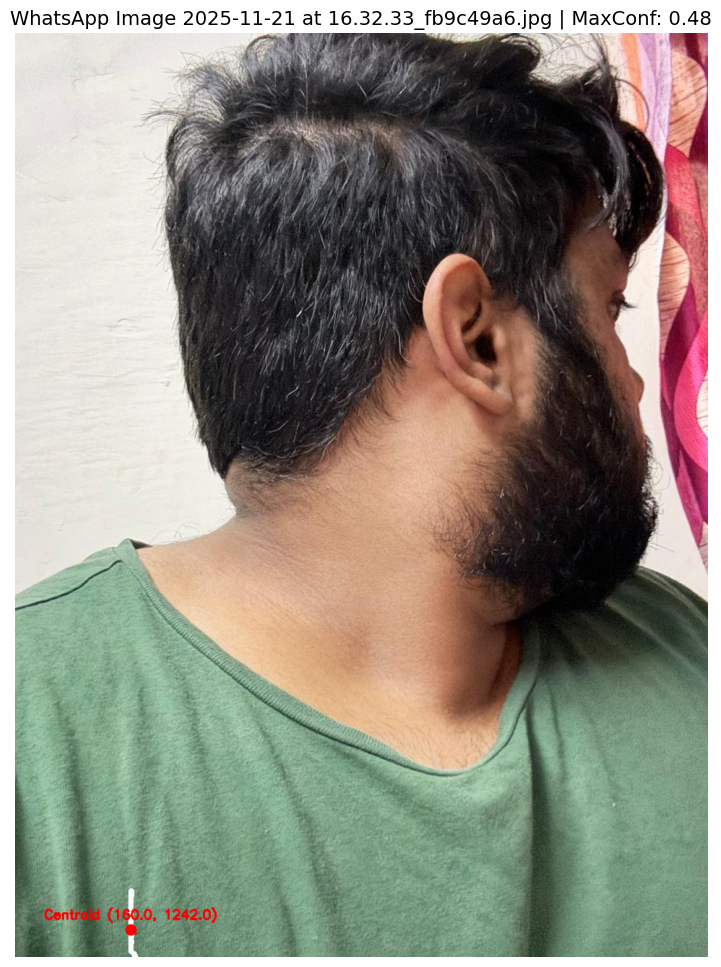


[2/3] Processing: WhatsApp Image 2025-11-21 at 16.33.50_27b3d39e.jpg
    Max Conf: 0.9993


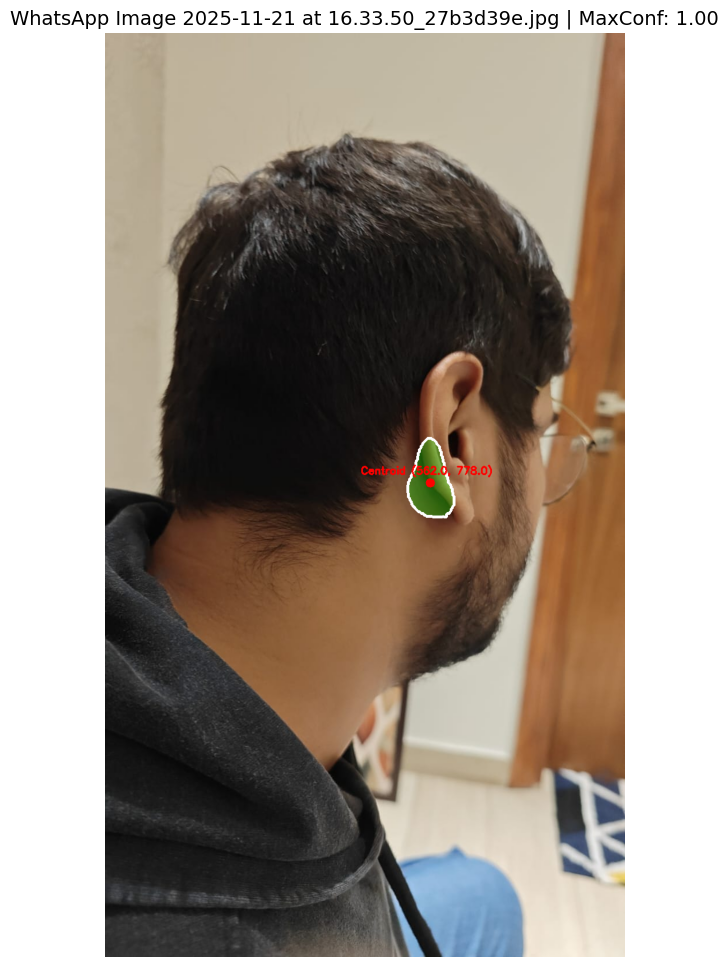


[3/3] Processing: WhatsApp Image 2025-11-21 at 16.34.23_5518cace.jpg
    Max Conf: 0.7704


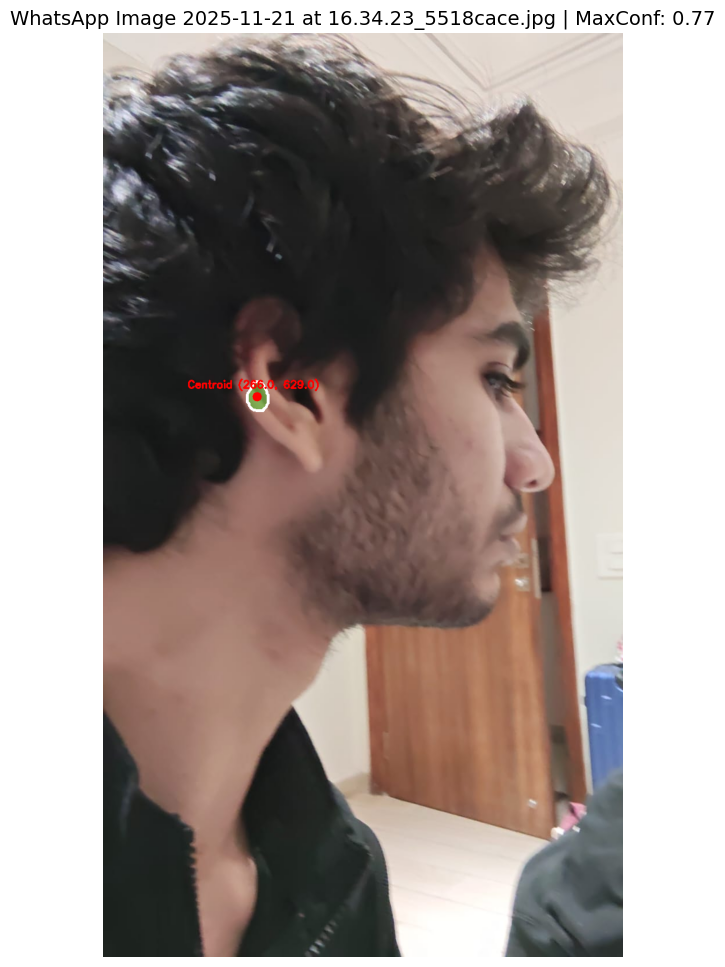

In [11]:
import os
import cv2
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO
import urllib.parse

# Install Inference Dependencies
os.system('pip install -q onnxruntime-gpu')

class PatchPredictor:
    def __init__(self, onnx_model_path, yolo_model_path='yolo11n-seg.pt'):
        print(f"Loading ONNX Model: {onnx_model_path}...")
        
        providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
        try:
            self.session = ort.InferenceSession(str(onnx_model_path), providers=providers)
        except Exception:
            print("CUDA not found. Falling back to CPU.")
            self.session = ort.InferenceSession(str(onnx_model_path), providers=['CPUExecutionProvider'])
            
        self.input_name = self.session.get_inputs()[0].name
        self.img_size = 512
        
        print("Loading YOLO for Smart Cropping...")
        self.yolo = YOLO(yolo_model_path)

    def preprocess(self, image_path):
        img_bgr = cv2.imread(str(image_path))
        if img_bgr is None: raise ValueError(f"Image not found: {image_path}")
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        h, w = img_rgb.shape[:2]

        # Smart Crop
        infer_img = img_rgb.copy()
        if max(h, w) > 1500:
            scale = 1500 / max(h, w)
            infer_img = cv2.resize(img_rgb, (0,0), fx=scale, fy=scale)
        
        results = self.yolo(infer_img, verbose=False, retina_masks=False)
        
        person_mask = np.zeros((h, w), dtype=np.uint8)
        if results[0].masks:
            boxes = results[0].boxes
            persons = boxes.cls == 0
            if persons.any():
                idx = results[0].boxes.conf[persons].argmax()
                real_idx = persons.nonzero(as_tuple=True)[0][idx]
                m = results[0].masks.data[real_idx].cpu().numpy()
                m = cv2.resize(m, (w, h))
                person_mask = (m > 0.5).astype(np.uint8)

        if np.sum(person_mask) > 0:
            rows = np.any(person_mask, axis=1)
            y_head_top = np.argmax(rows)
            cols = np.sum(person_mask, axis=0)
            center_x = int(np.dot(np.arange(w), cols) / (np.sum(cols)+1e-6))
        else:
            y_head_top = 0
            center_x = w // 2
        
        roi_height = h // 3
        square_dim = max(int(roi_height * 1.5), 256)
        center_y = y_head_top + (roi_height // 2)

        half = square_dim // 2
        x1, y1 = center_x - half, center_y - half
        x2, y2 = x1 + square_dim, y1 + square_dim

        pad_l, pad_t = max(0, -x1), max(0, -y1)
        pad_r, pad_b = max(0, x2 - w), max(0, y2 - h)

        padded_img = cv2.copyMakeBorder(img_rgb, pad_t, pad_b, pad_l, pad_r, cv2.BORDER_CONSTANT, value=[0,0,0])
        
        cx1, cy1 = x1 + pad_l, y1 + pad_t
        cx2, cy2 = cx1 + square_dim, cy1 + square_dim

        crop_img = padded_img[cy1:cy2, cx1:cx2]
        input_img = cv2.resize(crop_img, (self.img_size, self.img_size), interpolation=cv2.INTER_AREA)
        
        # Normalization
        norm_img = input_img.astype(np.float32) / 255.0
        norm_img = (norm_img - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
        
        blob = np.transpose(norm_img, (2, 0, 1))
        blob = np.expand_dims(blob, axis=0)
        
        meta = {
            'padded_img': padded_img,
            'crop_coords': (cx1, cy1, cx2, cy2),
            'pad_info': (pad_t, pad_l, h, w)
        }
        
        return blob.astype(np.float32), meta

    def predict_raw(self, input_tensor):
        outputs = self.session.run(None, {self.input_name: input_tensor})
        logits = outputs[0][0, 0, :, :]
        probs = 1 / (1 + np.exp(-logits))
        return probs

    def visualize(self, image_path):
        try:
            input_tensor, meta = self.preprocess(image_path)

            # --- Run ONNX ---
            probs = self.predict_raw(input_tensor)
            max_conf = float(np.max(probs))
            print(f"    Max Conf: {max_conf:.4f}")

            # --- STEP 1: Threshold probability map ---
            thresh = 0.3
            bin_mask = (probs > thresh).astype(np.uint8)

            # --- STEP 2: Remove tiny noise using morphology ---
            kernel = np.ones((3, 3), np.uint8)
            bin_mask = cv2.morphologyEx(bin_mask, cv2.MORPH_OPEN, kernel)

            # --- STEP 3: Connected Components ---
            num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
                bin_mask, connectivity=8
            )

            if num_labels <= 1:
                print("    No valid patch detected.")
                return

            # Ignore background (label 0)
            areas = stats[1:, cv2.CC_STAT_AREA]
            largest_label = 1 + np.argmax(areas)

            largest_mask = (labels == largest_label).astype(np.uint8)

            # --- STEP 4: Weighted centroid on largest chunk ---
            ys, xs = np.where(largest_mask == 1)
            weights = probs[ys, xs]

            total_weight = weights.sum()
            if total_weight < 1e-6:
                print("    Centroid unstable (low confidence).")
                return

            cx_512 = (xs * weights).sum() / total_weight
            cy_512 = (ys * weights).sum() / total_weight

            # --- STEP 5: Map centroid back to image ---
            padded_img = meta['padded_img']
            cx1, cy1, cx2, cy2 = meta['crop_coords']
            pad_t, pad_l, h, w = meta['pad_info']

            crop_w = cx2 - cx1
            crop_h = cy2 - cy1

            cx_crop = cx_512 * (crop_w / 512)
            cy_crop = cy_512 * (crop_h / 512)

            cx_full = int(cx1 + cx_crop)
            cy_full = int(cy1 + cy_crop)

            cx_orig = cx_full - pad_l
            cy_orig = cy_full - pad_t

            # --- STEP 6: Resize mask to crop size ---
            real_mask = cv2.resize(
                largest_mask,
                (crop_w, crop_h),
                interpolation=cv2.INTER_NEAREST
            )

            full_mask = np.zeros(
                (padded_img.shape[0], padded_img.shape[1]),
                dtype=np.uint8
            )
            full_mask[cy1:cy2, cx1:cx2] = real_mask

            # --- STEP 7: Visualization ---
            overlay = padded_img.copy()

            # Green segmentation overlay
            green = np.zeros_like(padded_img)
            green[:, :] = (0, 255, 0)

            overlay = np.where(
                full_mask[:, :, None] == 1,
                cv2.addWeighted(padded_img, 0.7, green, 0.3, 0),
                padded_img
            )

            # Draw contour
            contours, _ = cv2.findContours(
                full_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
            )
            cv2.drawContours(overlay, contours, -1, (255, 255, 255), 3)

            # Draw centroid (RED DOT)
            cv2.circle(
                overlay,
                (cx_full, cy_full),
                radius=8,
                color=(255, 0, 0),
                thickness=-1
            )

            # Label centroid
            cv2.putText(
                overlay,
                f"Centroid ({cx_orig:.1f}, {cy_orig:.1f})",
                (max(cx_full - 120, 10), max(cy_full - 15, 30)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (255, 0, 0),
                2
            )

            # Remove padding
            final_view = overlay[pad_t:pad_t + h, pad_l:pad_l + w]

            # --- Display ---
            plt.figure(figsize=(12, 12))
            plt.imshow(final_view)
            plt.axis("off")
            plt.title(
                f"{image_path.name} | MaxConf: {max_conf:.2f}",
                fontsize=14
            )
            plt.show()

        except Exception as e:
            print(f"    Error processing {image_path.name}: {str(e)}")


if __name__ == "__main__":
    ONNX_PATH = Path(r"D:\Work\Projects\Device-Patch-Placement\Device-Placement-Model\Notebooks\device_segmentation.onnx")
    
    # Update this path to your target directory
    RAW_DIR = Path("./test")
    
    if ONNX_PATH.exists():
        predictor = PatchPredictor(ONNX_PATH)
        
        # Gather all images
        all_images = sorted(list(RAW_DIR.glob("*.jpg")) + list(RAW_DIR.glob("*.png")) + list(RAW_DIR.glob("*.jpeg")))
        
        if all_images:
            print(f"Found {len(all_images)} images in directory. Processing all...")
            for idx, test_img in enumerate(all_images):
                print(f"\n[{idx+1}/{len(all_images)}] Processing: {test_img.name}")
                predictor.visualize(test_img)
        else:
            print("No images found to test.")
    else:
        print("Please run training first.")

[INFO] Loading ONNX model (CPU only): D:\Work\Projects\Device-Patch-Placement\Device-Placement-Model\Notebooks\device_segmentation.onnx
[INFO] Loading YOLO (CPU only)
[INFO] Found 3 images

[1/3] Processing WhatsApp Image 2025-11-21 at 16.32.33_fb9c49a6.jpg
[INFO] Max confidence: 1.0000


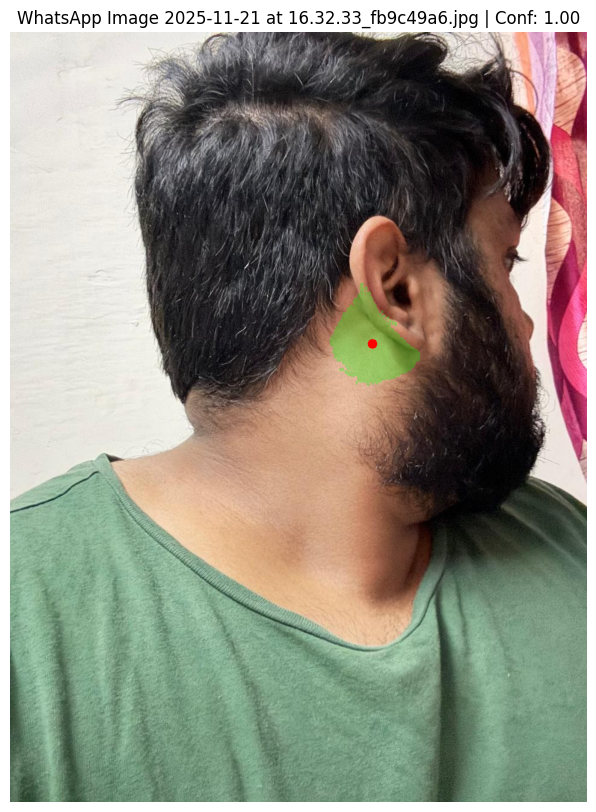


[2/3] Processing WhatsApp Image 2025-11-21 at 16.33.50_27b3d39e.jpg
[INFO] Max confidence: 0.9997


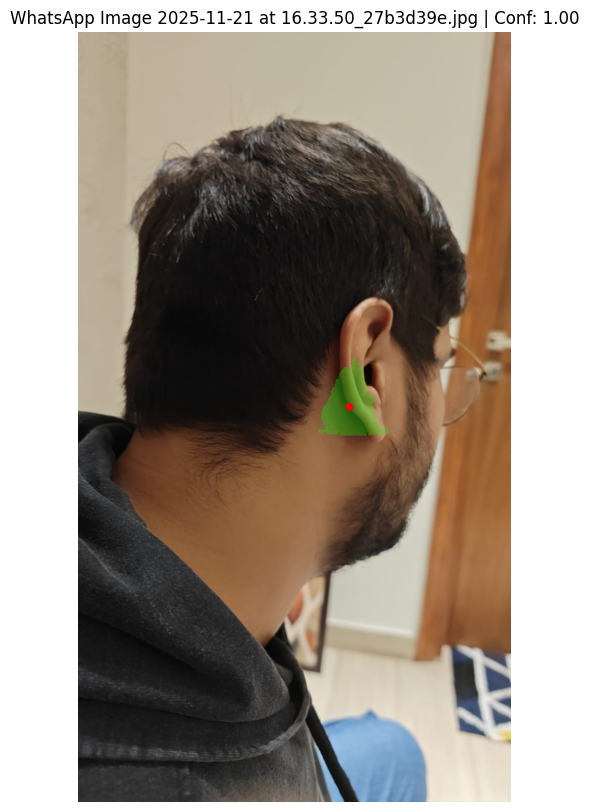


[3/3] Processing WhatsApp Image 2025-11-21 at 16.34.23_5518cace.jpg
[INFO] Max confidence: 0.6866


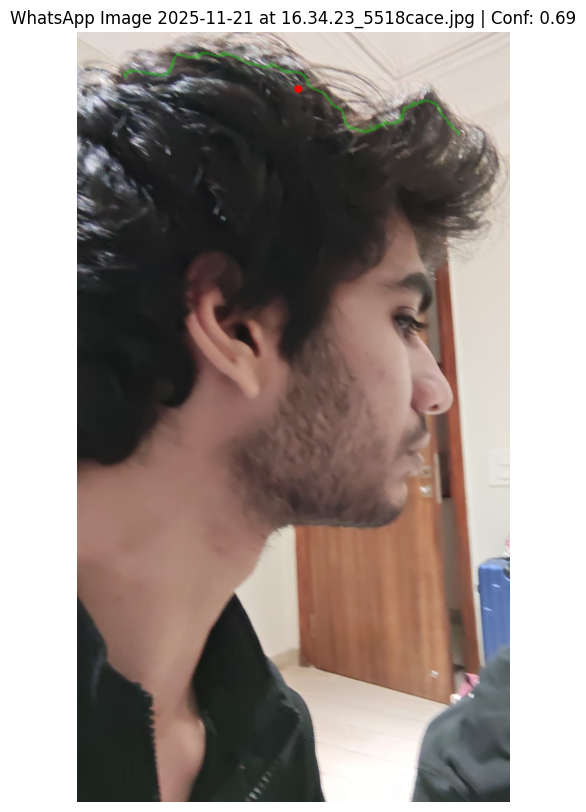

In [12]:
import os
import cv2
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO

# ---------------- CONFIG ----------------
IMG_SIZE = 512
MIN_CONF = 0.5
PERCENTILE_THRESH = 90

# ---------------------------------------


class PatchPredictor:
    def __init__(self, onnx_model_path, yolo_model_path="yolo11n-seg.pt"):
        print(f"[INFO] Loading ONNX model (CPU only): {onnx_model_path}")

        # Force CPU for deterministic behavior
        self.session = ort.InferenceSession(
            str(onnx_model_path),
            providers=["CPUExecutionProvider"]
        )
        self.input_name = self.session.get_inputs()[0].name

        print("[INFO] Loading YOLO (CPU only)")
        self.yolo = YOLO(yolo_model_path)
        self.yolo.to("cpu")

    # ---------------- PREPROCESS ----------------
    def preprocess(self, image_path):
        img_bgr = cv2.imread(str(image_path))
        if img_bgr is None:
            raise ValueError(f"Image not found: {image_path}")

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        h, w = img_rgb.shape[:2]

        # ---- YOLO inference (stabilized) ----
        results = self.yolo(
            img_rgb,
            conf=0.25,
            iou=0.5,
            agnostic_nms=True,
            max_det=1,
            verbose=False,
            retina_masks=False
        )[0]

        person_mask = np.zeros((h, w), dtype=np.uint8)

        if results.masks is not None and results.boxes is not None:
            persons = results.boxes.cls == 0
            if persons.any():
                idx = results.boxes.conf[persons].argmax()
                real_idx = persons.nonzero(as_tuple=True)[0][idx]
                mask = results.masks.data[real_idx].cpu().numpy()
                mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
                person_mask = (mask > 0.5).astype(np.uint8)

        # ---- Stable crop center estimation ----
        if person_mask.sum() > 0:
            rows = np.any(person_mask, axis=1)
            cols = np.any(person_mask, axis=0)

            y_indices = np.where(rows)[0]
            x_indices = np.where(cols)[0]

            y_head_top = int(y_indices.min())
            center_x = int(np.median(x_indices))
        else:
            y_head_top = 0
            center_x = w // 2

        roi_height = h // 3
        square_dim = max(int(roi_height * 1.5), 256)
        center_y = y_head_top + roi_height // 2

        # Clamp crop to reduce jitter
        center_x = int(np.clip(center_x, w * 0.3, w * 0.7))
        center_y = int(np.clip(center_y, h * 0.1, h * 0.5))

        half = square_dim // 2
        x1, y1 = center_x - half, center_y - half
        x2, y2 = x1 + square_dim, y1 + square_dim

        pad_l = max(0, -x1)
        pad_t = max(0, -y1)
        pad_r = max(0, x2 - w)
        pad_b = max(0, y2 - h)

        padded_img = cv2.copyMakeBorder(
            img_rgb, pad_t, pad_b, pad_l, pad_r,
            cv2.BORDER_CONSTANT, value=[0, 0, 0]
        )

        cx1, cy1 = x1 + pad_l, y1 + pad_t
        cx2, cy2 = cx1 + square_dim, cy1 + square_dim

        crop_img = padded_img[cy1:cy2, cx1:cx2]
        crop_img = cv2.resize(crop_img, (IMG_SIZE, IMG_SIZE), cv2.INTER_AREA)

        # ---- Normalization (unchanged) ----
        img = crop_img.astype(np.float32) / 255.0
        img = (img - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]

        blob = img.transpose(2, 0, 1)[None].astype(np.float32)

        meta = {
            "padded_img": padded_img,
            "crop_coords": (cx1, cy1, cx2, cy2),
            "pad_info": (pad_t, pad_l, h, w)
        }

        return blob, meta

    # ---------------- ONNX INFERENCE ----------------
    def predict_raw(self, input_tensor):
        logits = self.session.run(None, {self.input_name: input_tensor})[0][0, 0]
        probs = 1 / (1 + np.exp(-logits))
        return probs

    # ---------------- VISUALIZATION ----------------
    def visualize(self, image_path):
        try:
            input_tensor, meta = self.preprocess(image_path)
            probs = self.predict_raw(input_tensor)

            max_conf = float(probs.max())
            print(f"[INFO] Max confidence: {max_conf:.4f}")

            if max_conf < MIN_CONF:
                print("[WARN] Low confidence — skipping")
                return

            thresh = np.percentile(probs, PERCENTILE_THRESH)
            bin_mask = (probs > thresh).astype(np.uint8)

            kernel = np.ones((3, 3), np.uint8)
            bin_mask = cv2.morphologyEx(bin_mask, cv2.MORPH_OPEN, kernel)

            num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
                bin_mask, connectivity=8
            )

            if num_labels <= 1:
                print("[WARN] No valid component")
                return

            scores = []
            for i in range(1, num_labels):
                area = stats[i, cv2.CC_STAT_AREA]
                mean_conf = probs[labels == i].mean()
                scores.append(area * mean_conf)

            largest_label = 1 + np.argmax(scores)
            mask = (labels == largest_label).astype(np.uint8)

            ys, xs = np.where(mask == 1)
            weights = probs[ys, xs]
            total_weight = weights.sum()

            if total_weight < 50:
                print("[WARN] Unstable centroid")
                return

            cx_512 = (xs * weights).sum() / total_weight
            cy_512 = (ys * weights).sum() / total_weight

            padded_img = meta["padded_img"]
            cx1, cy1, cx2, cy2 = meta["crop_coords"]
            pad_t, pad_l, h, w = meta["pad_info"]

            crop_w = cx2 - cx1
            crop_h = cy2 - cy1

            cx_full = int(cx1 + cx_512 * (crop_w / IMG_SIZE))
            cy_full = int(cy1 + cy_512 * (crop_h / IMG_SIZE))

            cx_orig = cx_full - pad_l
            cy_orig = cy_full - pad_t

            overlay = padded_img.copy()
            green = np.zeros_like(padded_img)
            green[:] = (0, 255, 0)

            resized_mask = cv2.resize(mask, (crop_w, crop_h), cv2.INTER_NEAREST)
            full_mask = np.zeros(padded_img.shape[:2], dtype=np.uint8)
            full_mask[cy1:cy2, cx1:cx2] = resized_mask

            overlay = np.where(
                full_mask[..., None] == 1,
                cv2.addWeighted(padded_img, 0.7, green, 0.3, 0),
                padded_img
            )

            cv2.circle(overlay, (cx_full, cy_full), 8, (255, 0, 0), -1)
            final_view = overlay[pad_t:pad_t + h, pad_l:pad_l + w]

            plt.figure(figsize=(10, 10))
            plt.imshow(final_view)
            plt.axis("off")
            plt.title(f"{image_path.name} | Conf: {max_conf:.2f}")
            plt.show()

        except Exception as e:
            print(f"[ERROR] {image_path.name}: {e}")


# ---------------- MAIN ----------------
if __name__ == "__main__":
    ONNX_PATH = Path(r"D:\Work\Projects\Device-Patch-Placement\Device-Placement-Model\Notebooks\device_segmentation.onnx")
    RAW_DIR = Path("./test")

    if not ONNX_PATH.exists():
        print("[ERROR] ONNX model not found.")
        exit()

    predictor = PatchPredictor(ONNX_PATH)

    images = list(RAW_DIR.glob("*.jpg")) + list(RAW_DIR.glob("*.png")) + list(RAW_DIR.glob("*.jpeg"))
    images.sort()

    print(f"[INFO] Found {len(images)} images")

    for idx, img in enumerate(images):
        print(f"\n[{idx+1}/{len(images)}] Processing {img.name}")
        predictor.visualize(img)


## Centroid of the Patch

In [36]:
import cv2
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt


In [61]:
import onnxruntime as ort

def create_onnx_session(onnx_path):
    available = ort.get_available_providers()
    print("Available providers:", available)

    providers = []

    # 1️⃣ TensorRT (FASTEST, if available)
    if "TensorrtExecutionProvider" in available:
        providers.append((
            "TensorrtExecutionProvider",
            {
                "device_id": 0,
                "trt_engine_cache_enable": True,
                "trt_engine_cache_path": "./trt_cache",
                "trt_fp16_enable": True,          # set False if you want strict FP32
                "trt_int8_enable": False,         # enable only if calibrated
                "trt_max_workspace_size": 1 << 30 # 1GB workspace
            }
        ))
        print("[INFO] TensorRT enabled")

    # 2️⃣ CUDA (fallback if TensorRT can't compile some ops)
    if "CUDAExecutionProvider" in available:
        providers.append((
            "CUDAExecutionProvider",
            {
                "device_id": 0,
                "cudnn_conv_algo_search": "EXHAUSTIVE",
                "arena_extend_strategy": "kNextPowerOfTwo"
            }
        ))
        print("[INFO] CUDA enabled")

    # 3️⃣ CPU (final fallback)
    providers.append("CPUExecutionProvider")

    session = ort.InferenceSession(
        onnx_path,
        providers=providers
    )

    print("Active providers:", session.get_providers())
    return session


In [62]:
def load_and_downscale_patch(patch_png_path, scale=45):
    patch = cv2.imread(patch_png_path, cv2.IMREAD_UNCHANGED)
    if patch is None:
        raise ValueError("Patch PNG not found")

    if patch.shape[2] == 3:
        alpha = np.ones((patch.shape[0], patch.shape[1], 1), dtype=np.uint8) * 255
        patch = np.concatenate([patch, alpha], axis=2)

    patch[:, :, :3] = cv2.cvtColor(patch[:, :, :3], cv2.COLOR_BGR2RGB)

    h, w = patch.shape[:2]
    patch_small = cv2.resize(
        patch,
        (max(1, w // scale), max(1, h // scale)),
        interpolation=cv2.INTER_AREA
    )
    return patch_small


In [63]:
def load_and_downscale_patch(patch_png_path, scale=45):
    patch = cv2.imread(patch_png_path, cv2.IMREAD_UNCHANGED)
    if patch is None:
        raise ValueError("Patch PNG not found")

    # Add alpha if missing
    if patch.shape[2] == 3:
        alpha = np.ones((patch.shape[0], patch.shape[1], 1), dtype=np.uint8) * 255
        patch = np.concatenate([patch, alpha], axis=2)

    patch[:, :, :3] = cv2.cvtColor(patch[:, :, :3], cv2.COLOR_BGR2RGB)

    h, w = patch.shape[:2]
    patch_small = cv2.resize(
        patch,
        (max(1, w // scale), max(1, h // scale)),
        interpolation=cv2.INTER_AREA
    )

    return patch_small


In [64]:
def patch_centroid(patch):
    alpha = patch[:, :, 3].astype(np.float32) / 255.0
    if alpha.sum() < 1e-6:
        raise ValueError("Patch fully transparent")

    ys, xs = np.indices(alpha.shape)
    cx = (xs * alpha).sum() / alpha.sum()
    cy = (ys * alpha).sum() / alpha.sum()
    return cx, cy


In [65]:
def overlay_patch(base_img, patch, target_cx, target_cy):
    ph, pw = patch.shape[:2]
    base_h, base_w = base_img.shape[:2]

    pcx, pcy = patch_centroid(patch)

    x1 = int(target_cx - pcx)
    y1 = int(target_cy - pcy)
    x2 = x1 + pw
    y2 = y1 + ph

    bx1, by1 = max(0, x1), max(0, y1)
    bx2, by2 = min(base_w, x2), min(base_h, y2)

    if bx1 >= bx2 or by1 >= by2:
        return base_img

    px1, py1 = bx1 - x1, by1 - y1
    px2, py2 = px1 + (bx2 - bx1), py1 + (by2 - by1)

    patch_crop = patch[py1:py2, px1:px2]

    overlay = base_img.copy()
    alpha = patch_crop[:, :, 3:4].astype(np.float32) / 255.0
    rgb = patch_crop[:, :, :3].astype(np.float32)
    bg = overlay[by1:by2, bx1:bx2].astype(np.float32)

    blended = bg * (1 - alpha) + rgb * alpha
    overlay[by1:by2, bx1:bx2] = blended.astype(np.uint8)

    return overlay


In [66]:
def overlay_patch(base_img, patch, target_cx, target_cy):
    ph, pw = patch.shape[:2]
    base_h, base_w = base_img.shape[:2]

    pcx, pcy = patch_centroid(patch)

    x1 = int(target_cx - pcx)
    y1 = int(target_cy - pcy)
    x2 = x1 + pw
    y2 = y1 + ph

    bx1, by1 = max(0, x1), max(0, y1)
    bx2, by2 = min(base_w, x2), min(base_h, y2)

    if bx1 >= bx2 or by1 >= by2:
        return base_img

    px1, py1 = bx1 - x1, by1 - y1
    px2, py2 = px1 + (bx2 - bx1), py1 + (by2 - by1)

    patch_crop = patch[py1:py2, px1:px2]

    overlay = base_img.copy()
    alpha = patch_crop[:, :, 3:4].astype(np.float32) / 255.0
    rgb = patch_crop[:, :, :3].astype(np.float32)
    bg = overlay[by1:by2, bx1:bx2].astype(np.float32)

    blended = bg * (1 - alpha) + rgb * alpha
    overlay[by1:by2, bx1:bx2] = blended.astype(np.uint8)

    return overlay


In [67]:
def visualize_prediction_and_patch(
    onnx_path,
    image_path,
    patch_png_path
):
    # 1️⃣ Predict patch area + centroid
    base_img, patch_mask, (cx, cy) = predict_patch_area_and_centroid(
        onnx_path,
        image_path
    )

    # 2️⃣ Overlay predicted patch area (green)
    green = np.zeros_like(base_img)
    green[:] = (0, 255, 0)

    overlay_area = np.where(
        patch_mask[:, :, None] == 1,
        cv2.addWeighted(base_img, 0.7, green, 0.3, 0),
        base_img
    )

    # 3️⃣ Load & downscale patch
    patch_small = load_and_downscale_patch(patch_png_path, scale=25)

    # 4️⃣ Overlay patch
    final = overlay_patch(overlay_area, patch_small, cx, cy)

    # 5️⃣ Draw centroid
    cv2.circle(final, (cx, cy), 6, (255, 0, 0), -1)

    # 6️⃣ Show
    plt.figure(figsize=(10, 10))
    plt.imshow(final)
    plt.title("Predicted Patch Area + Centroid + Device Patch (45×)")
    plt.axis("off")
    plt.show()


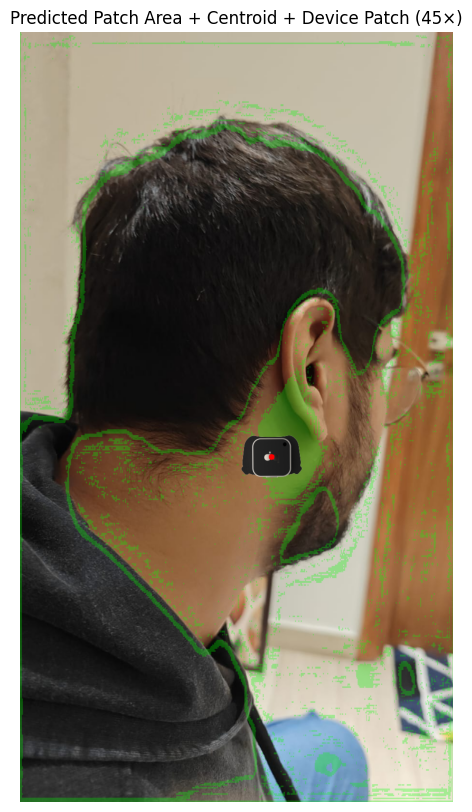

In [68]:
if __name__ == "__main__":
    visualize_prediction_and_patch(
        onnx_path="device_segmentation.onnx",
        image_path=r"D:\Work\Projects\Device-Patch-Placement\Device-Placement-Model\Notebooks\test\WhatsApp Image 2025-11-21 at 16.33.50_27b3d39e.jpg",
        patch_png_path="patch (9).png"
    )


In [58]:
import onnx
model = onnx.load(r"D:\Work\Projects\Device-Patch-Placement\Device-Placement-Model\Notebooks\device_segmentation.onnx")
print(model.opset_import)

[version: 11
]
